#Precision Recall Curves

Updated 6/19/15

Includes both calibrated and uncalibrated estimators

Uncalibrated:
- adaboost
- GaussianNB
- LR      (Logistic Regression, auto weights)
- LR5     (Logistic Regression, weight True = 5)
- LR-none (Logistic Regression, no weighting)
- svc     (SVC with rbf kernel)
- svclin  (SVC with linear kernel

Calibrated:
- adaboost - cal
- nb - cal  (caligrated GaussianNB)
- svclin - cal
- svc - cal

Also includes:
- Composite graphs showing TP/FP/FN and Precision/Recall/F1
- Drill-down graphs for individual solvers, including histograms of probability estimates
- Attempt at compositite solver
 - Result matrix combining Adaboost, LR and SVC
 - Compositive solver: Adaboost, LR and SVC
 - Composite solver: LR + LR-none

Notes:  Results are for OpenStack Nova, 8000+ features currently subsetted to 2000 features with freatest variance meacured bu Chi2

In [1]:
%matplotlib inline
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
import pickle

import sklearn
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import sklearn.tree
import sklearn.ensemble

from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import SGDClassifier

import sys
sys.path.append('../dev')
from ml_plot import get_dataset
from ml_plot import getClassifierProbs
from ml_plot import plotThresholdDistribuition, plotPredictionStats
from ml_plot import plotCombinedResults

from ml_plot import applyThreshold
from ml_plot import plotPrecisionRecall, plotAllPrecisionRecall
from ml_plot import showScatterProb

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression, f_classif

import sklearn.metrics

#Code

In [3]:
def plotSubsetCombinedResults(all_results, keys=[]):
    subset = {k:v for k, v in all_results.items()
          if k in keys}
    plotCombinedResults(subset)

In [17]:
# tally [svc][lr][ada][groundTruth]
def showConditionalProbs(lr_thresh=0.0,
                         svc_thresh=0.0,
                         ada_thresh=0.0):

    tally = [[[[0, 0], [0, 0]],
              [[0, 0], [0, 0]]],
             [[[0, 0], [0, 0]],
              [[0, 0], [0, 0]]]]
    
    groundTruth = np.concatenate([r['Y_test']
                          for r in all_results['LR']])
    lr_probs = np.concatenate([r['y_prob_net']
                          for r in all_results['LR']])
    svc_probs = np.concatenate([r['y_prob_net']
                          for r in all_results['svc - cal']])
    adaboost_probs = np.concatenate([r['y_prob_net']
                          for r in all_results['adaboost - cal']])
    
    for i, gt in enumerate(groundTruth):
        lr = 1 if lr_probs[i] >= lr_thresh else 0
        svc = 1 if svc_probs[i] >= svc_thresh else 0
        ada = 1 if adaboost_probs[i] >= ada_thresh else 0
        
        tally[svc][lr][ada][gt] += 1

    print 'LR SVC ADA'
    for lr in [0, 1]:
        for svc in [0, 1]:
            for ada in [0, 1]:
                instances = (tally[svc][lr][ada][0] + tally[svc][lr][ada][1])
                try:
                    prob  = (100.0 * tally[svc][lr][ada][1] / instances)
                    if instances < 10:
                        raise Exception
                    print '{}  {}   {}   Polarity: {:+0.1f}  Count: {:4d}  Prob1: {:0.1f}%'.format(lr, svc, ada,
                                                  lr + svc + ada - 1.5,
                                                  instances,
                                                  prob)
                except Exception:
                    print '{}  {}   {}   Polarity: {:+0.1f}  Count: {:4d}'.format(lr, svc, ada,
                                                  lr + svc + ada - 1.5, instances)

#Get Dataset

#####previously computed in ProbabilityCurves-Calibration notebook, limitted to 2000 features

In [4]:
with open('all_probability_results2.pkl', 'rb') as fd:
        all_results = pickle.load(fd)
        print 'Done'

Done


In [5]:
all_results.keys()

['adaboost - cal',
 'nb - cal',
 'GaussianNB',
 'svc',
 'svclin - cal',
 'LR5',
 'svc - cal',
 'LR-none',
 'LR',
 'svclin',
 'adaboost']

In [6]:
if 'adaboost' in all_results:
    del all_results['adaboost']

In [7]:
Y_test = np.concatenate([r['Y_test'] for r in all_results['LR']])
n_test = len(Y_test)
n_true = np.sum(Y_test)
pct_true = 100.0 * n_true / n_test
print 'Test feature set'
print '  Total: {}'.format(n_test)
print '   True: {}  ({:0.1f}%)'.format(n_true, pct_true)

Test feature set
  Total: 50000
   True: 10428  (20.9%)


In [8]:
for k in all_results.keys():
    print k
    try:
        ll = np.mean([sklearn.metrics.log_loss(r['Y_test'], r['y_prob_raw'])
                  for r in all_results[k]])
        br = np.mean([sklearn.metrics.brier_score_loss(r['Y_test'],
                                                   r['y_prob_raw'][:,1])
                  for r in all_results[k]])
        print '    log_loss: {:0.2f}  brier: {:0.2f}'.format(ll, br)
    except Exception:
        print '    Failed (probably brier)'

adaboost - cal
    log_loss: 0.43  brier: 0.14
nb - cal
    Failed (probably brier)
GaussianNB
    log_loss: 7.81  brier: 0.23
svc
    log_loss: 0.43  brier: 0.13
svclin - cal
    log_loss: 0.45  brier: 0.14
LR5
    log_loss: 0.61  brier: 0.20
svc - cal
    log_loss: 0.44  brier: 0.13
LR-none
    log_loss: 0.43  brier: 0.13
LR
    log_loss: 0.53  brier: 0.17
svclin
    log_loss: 0.46  brier: 0.15


#Show Combined Results

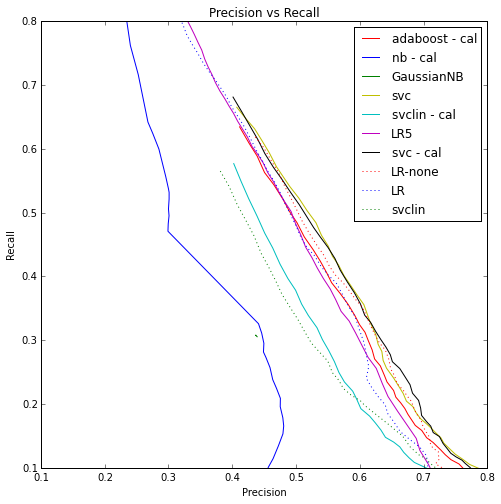

In [29]:
plotAllPrecisionRecall(all_results)
# plotCombinedResults(all_results)

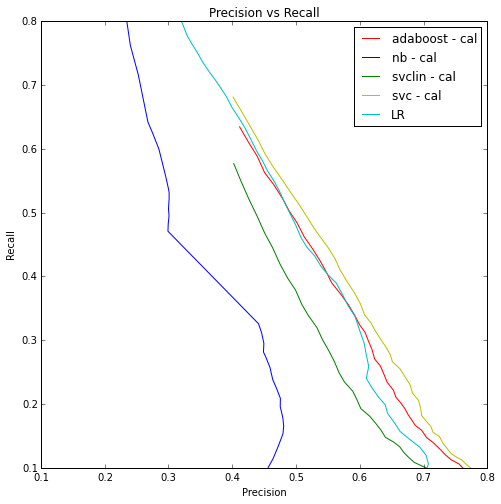

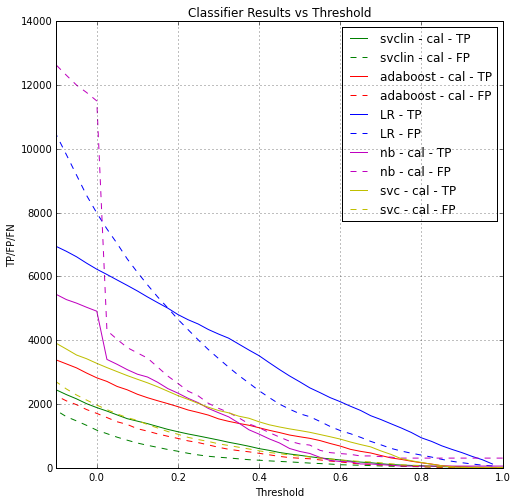

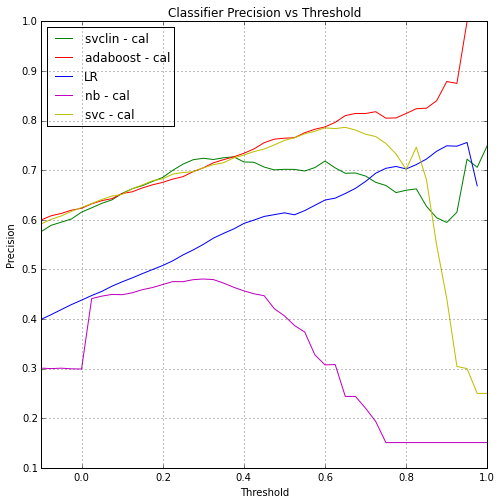

In [9]:
keys = ['adaboost - cal', 'nb - cal', 'svclin - cal', 'svc - cal', 'LR',]
plotAllPrecisionRecall(all_results,keys)
plotSubsetCombinedResults(all_results, keys)

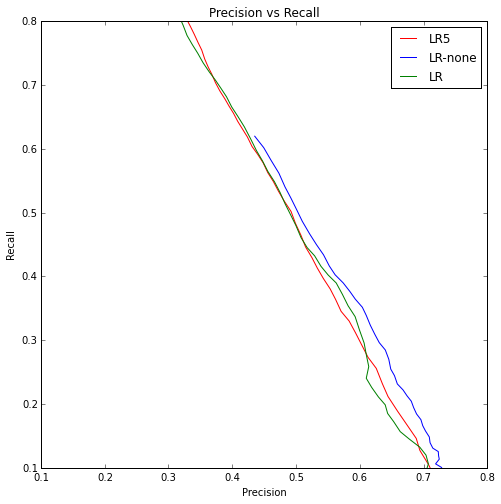

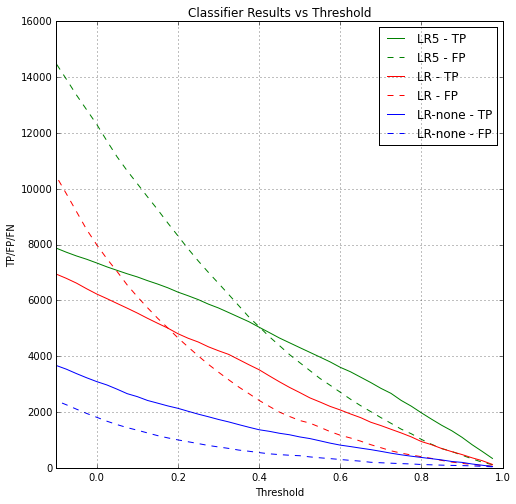

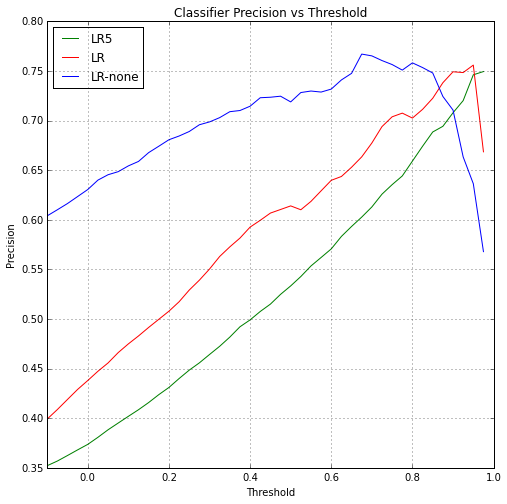

In [10]:
keys = ['LR5','LR-none','LR',]
plotAllPrecisionRecall(all_results,keys)
plotSubsetCombinedResults(all_results, keys)

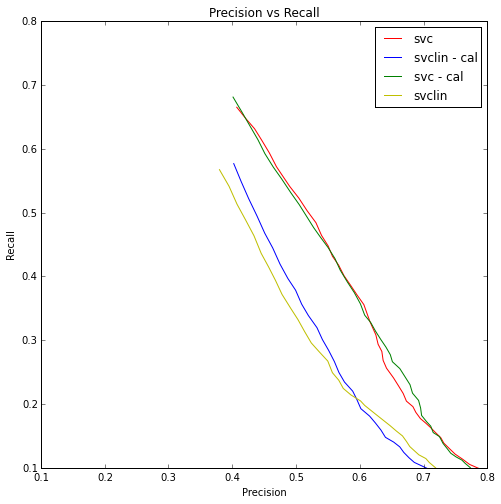

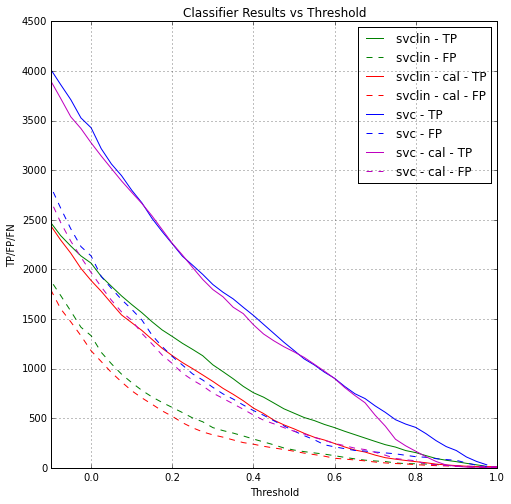

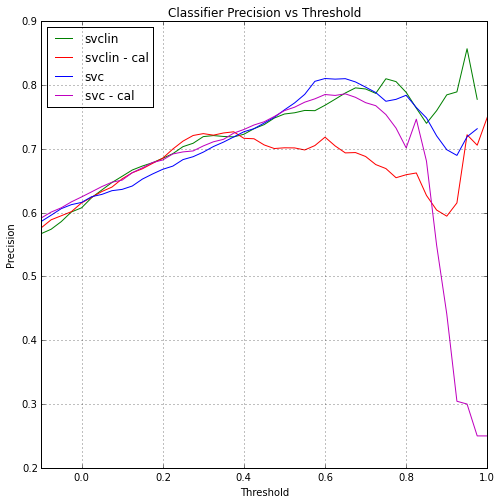

In [11]:
keys = ['svc','svclin - cal', 'svc - cal', 'svclin',]
plotAllPrecisionRecall(all_results,keys)
plotSubsetCombinedResults(all_results, keys)

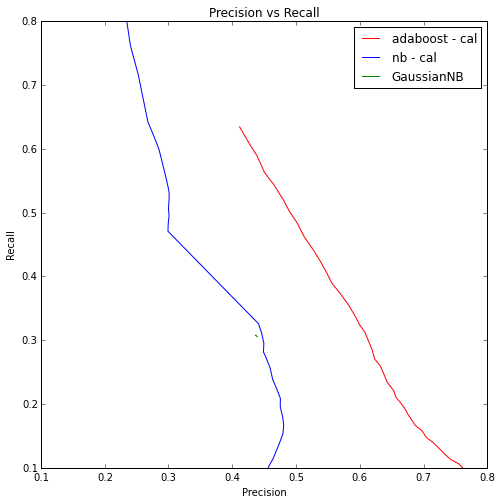

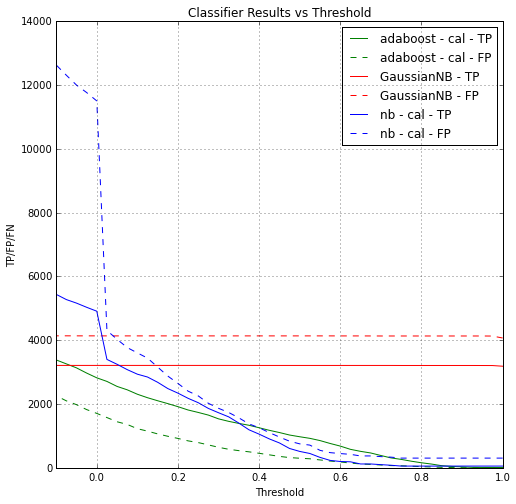

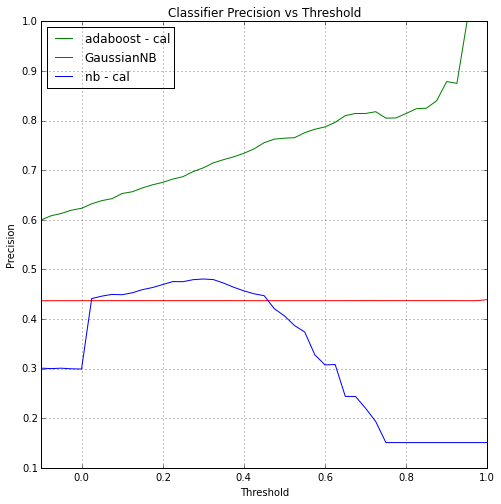

In [12]:
keys = ['adaboost - cal', 'nb - cal', 'GaussianNB', 'adaboost']
plotAllPrecisionRecall(all_results,keys)
plotSubsetCombinedResults(all_results, keys)

#Show for individual estimators

adaboost - cal


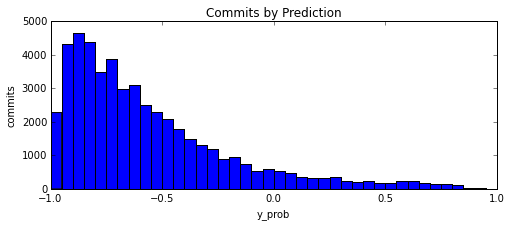

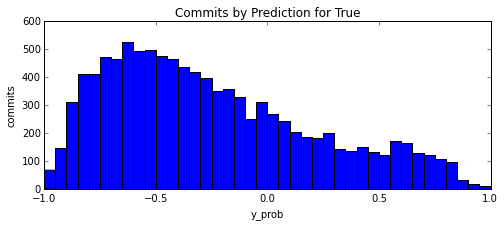

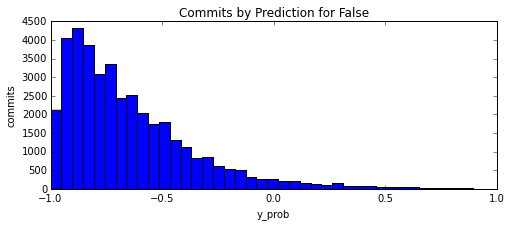

nb - cal


/Users/doug/anaconda/lib/python2.7/site-packages/numpy/core/function_base.py:99: RuntimeWarning: invalid value encountered in multiply
  y = _nx.arange(0, num, dtype=dtype) * step + start
/Users/doug/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:1114: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


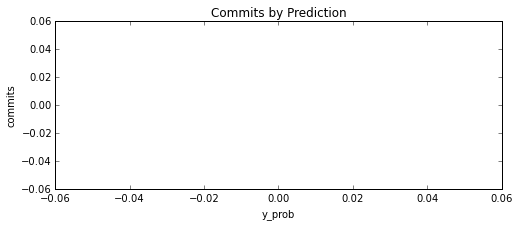

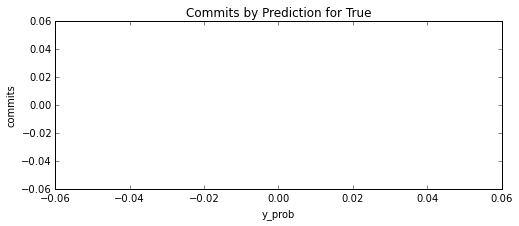

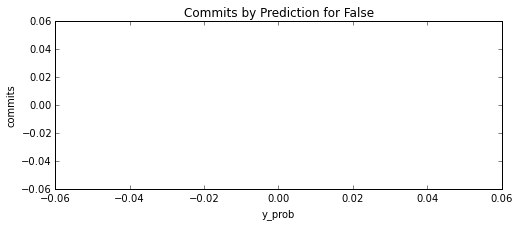

GaussianNB


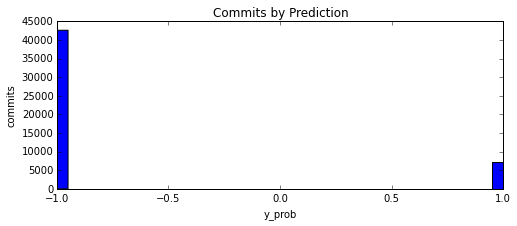

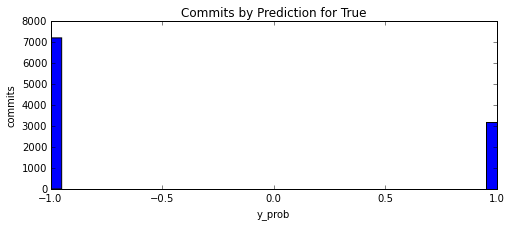

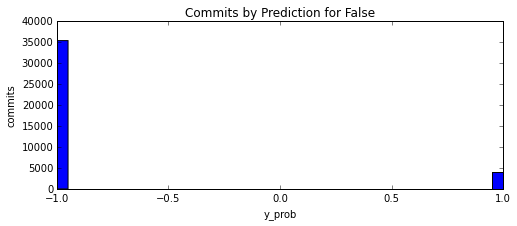

svc


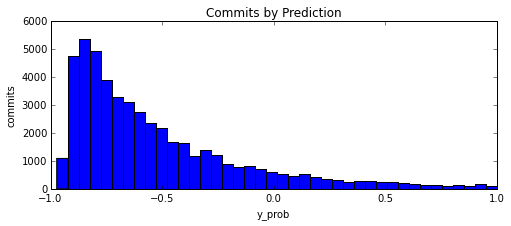

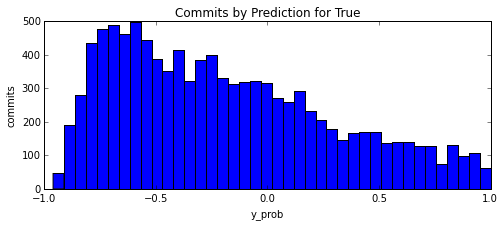

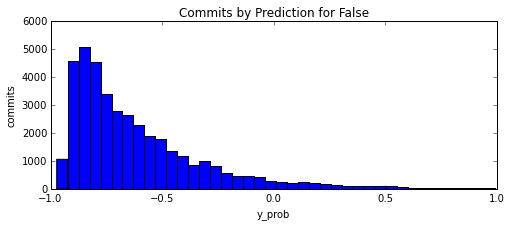

svclin - cal


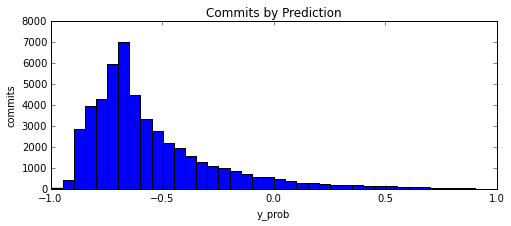

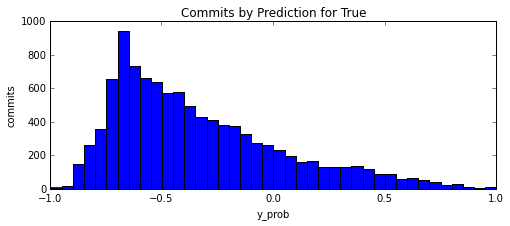

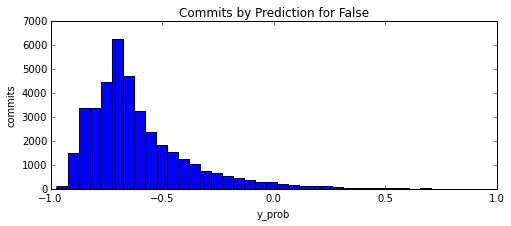

LR5


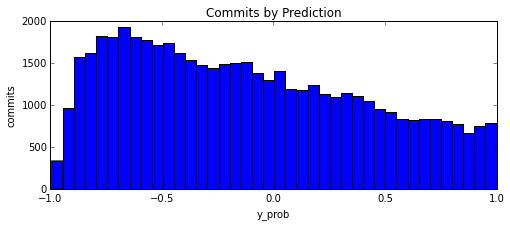

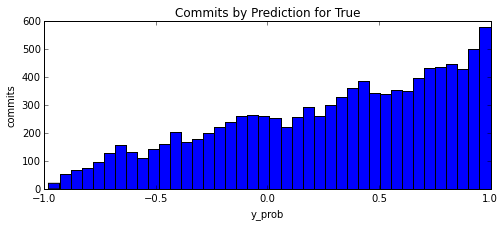

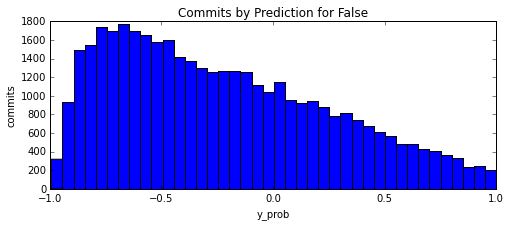

svc - cal


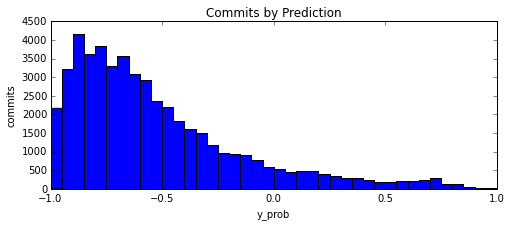

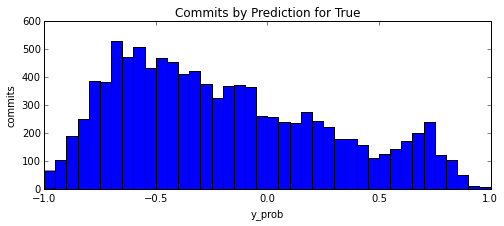

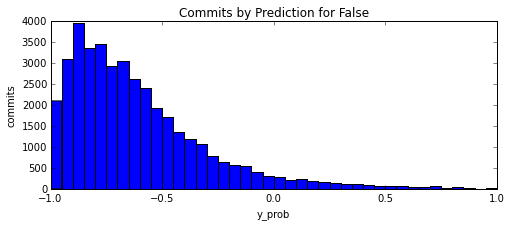

LR-none


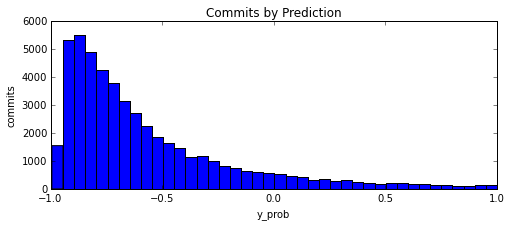

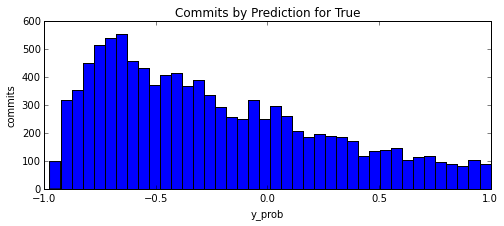

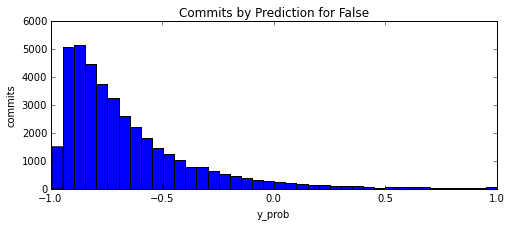

LR


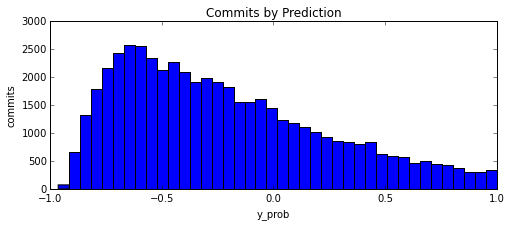

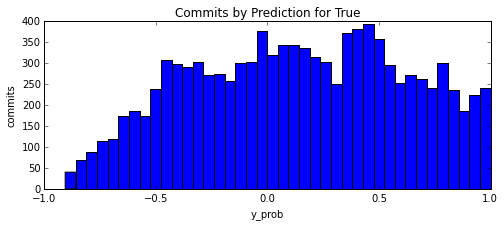

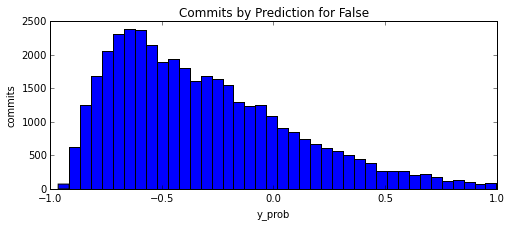

svclin


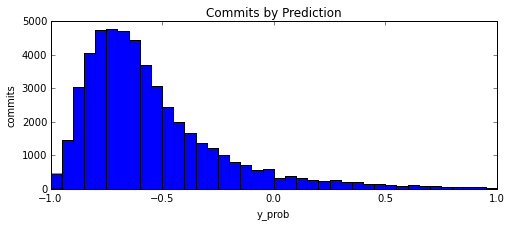

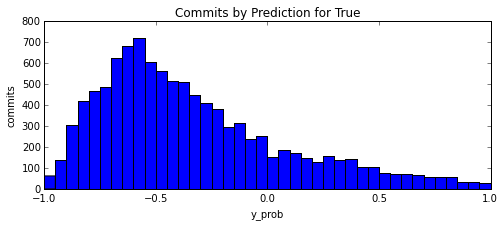

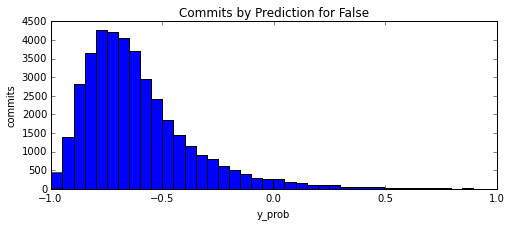

In [13]:
for k in all_results.keys():
    print k
    plotThresholdDistribuition(all_results[k])

adaboost - cal


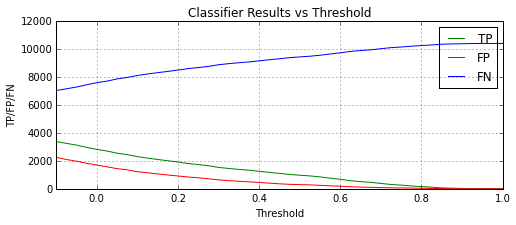

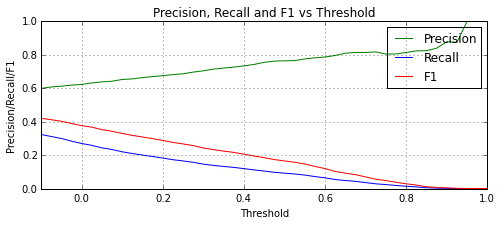

nb - cal


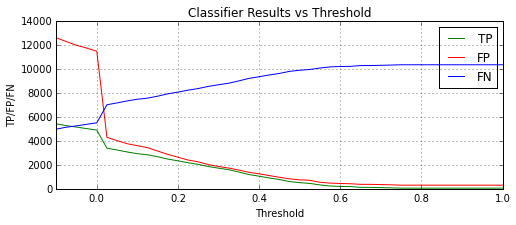

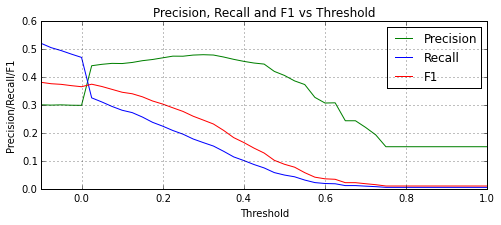

GaussianNB


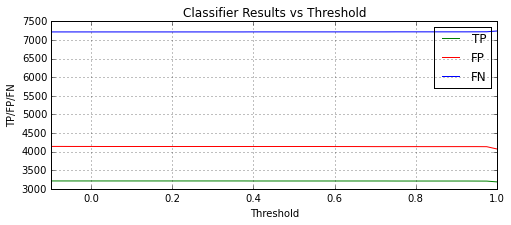

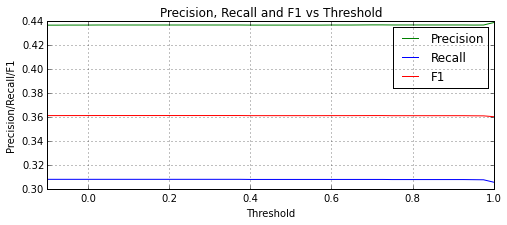

svc


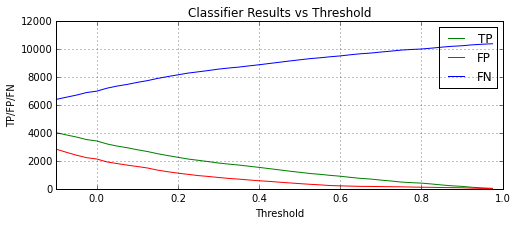

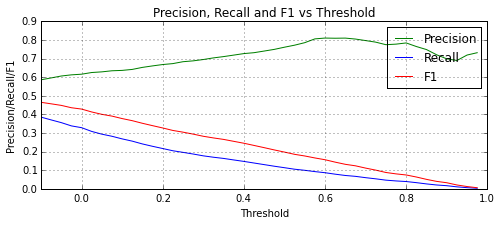

svclin - cal


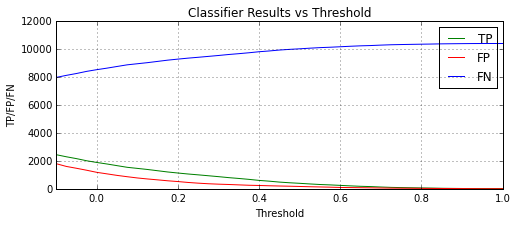

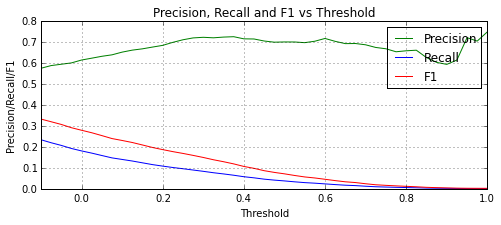

LR5


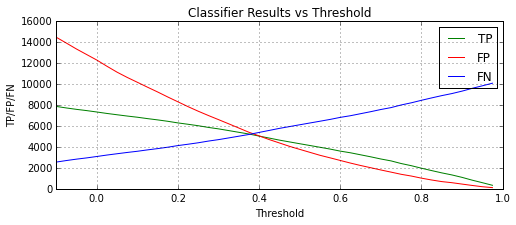

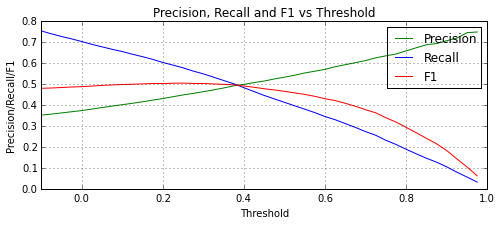

svc - cal


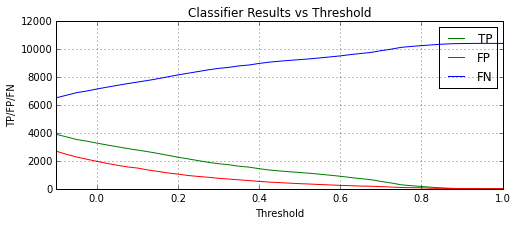

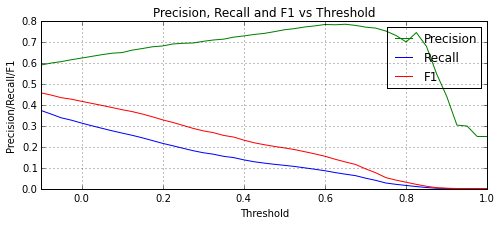

LR-none


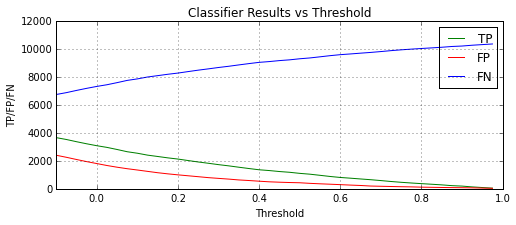

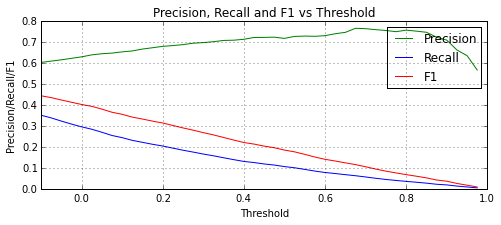

LR


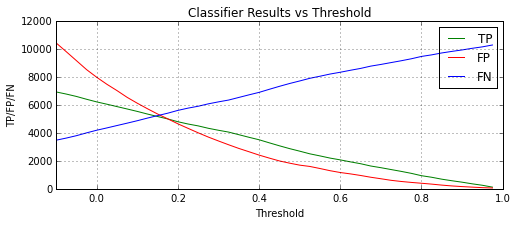

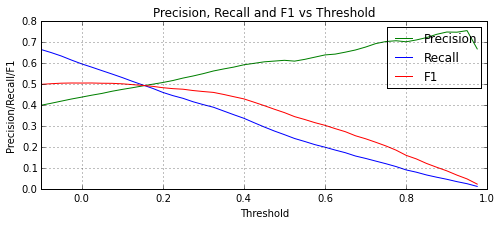

svclin


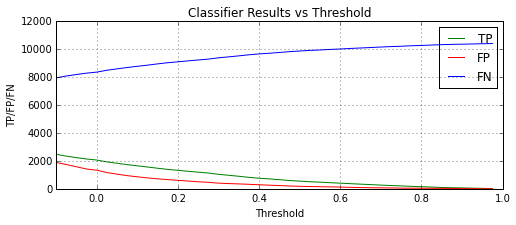

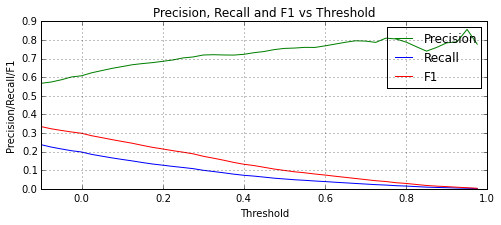

In [14]:
for k in all_results.keys():
    print k
    plotPredictionStats(all_results[k])

#Look at correlations between solvers

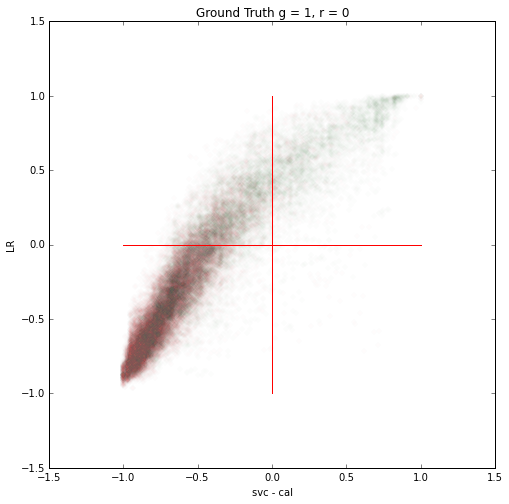

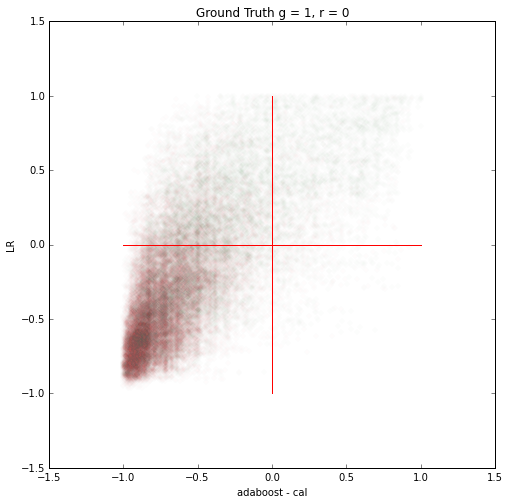

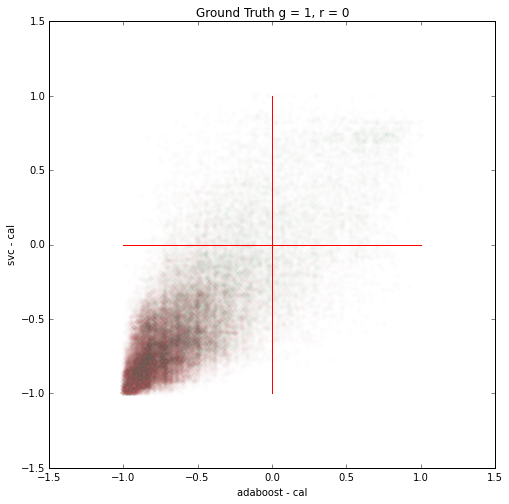

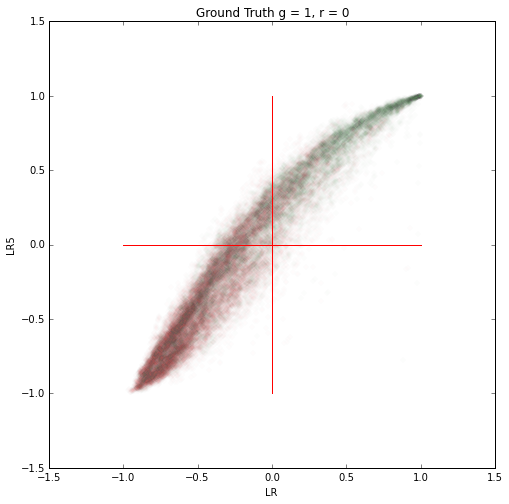

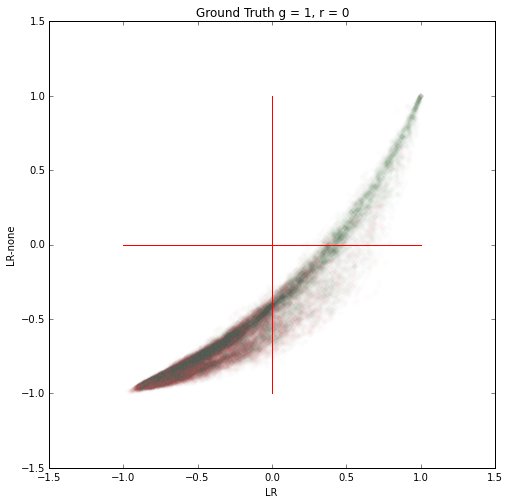

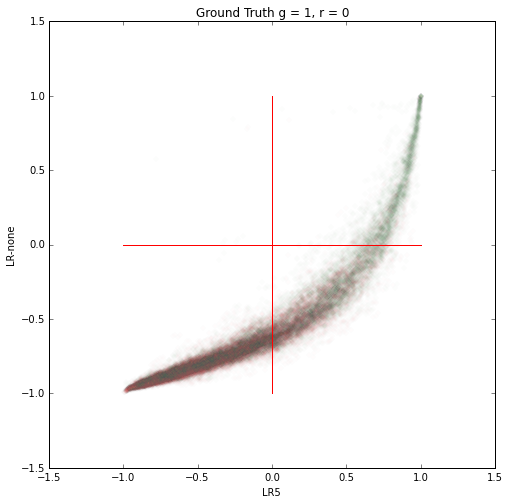

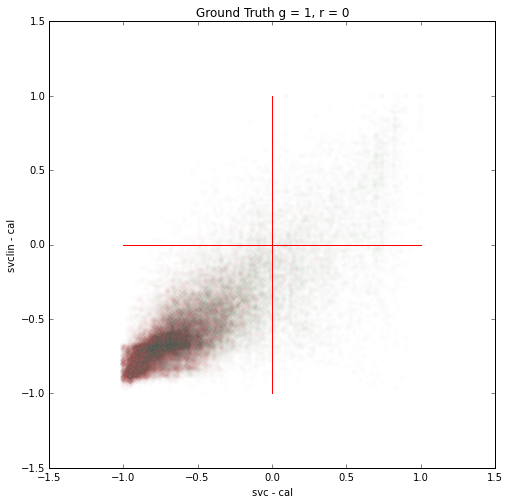

In [16]:
for firstKey, secondKey in [['svc - cal', 'LR'],
                            ['adaboost - cal', 'LR'],
                            ['adaboost - cal', 'svc - cal'],
                            ['LR', 'LR5'], ['LR', 'LR-none'],
                            ['LR5', 'LR-none'],
                            ['svc - cal', 'svclin - cal'] ]:
    showScatterProb(firstKey, secondKey, all_results)

#Explore Confitional Probabilities

In [18]:
showConditionalProbs(lr_thresh=0.0,
                         svc_thresh=0.0,
                         ada_thresh=0.0)

LR SVC ADA
0  0   0   Polarity: -1.5  Count: 35062  Prob1: 11.1%
0  0   1   Polarity: -0.5  Count:  599  Prob1: 42.2%
0  1   0   Polarity: -0.5  Count:   70  Prob1: 35.7%
0  1   1   Polarity: +0.5  Count:   50  Prob1: 92.0%
1  0   0   Polarity: -0.5  Count: 7969  Prob1: 31.8%
1  0   1   Polarity: +0.5  Count: 1127  Prob1: 43.4%
1  1   0   Polarity: +0.5  Count: 2371  Prob1: 49.4%
1  1   1   Polarity: +1.5  Count: 2752  Prob1: 73.9%


In [19]:
showConditionalProbs(lr_thresh=0.2,
                         svc_thresh=0.0,
                         ada_thresh=0.0)

LR SVC ADA
0  0   0   Polarity: -1.5  Count: 39215  Prob1: 12.9%
0  0   1   Polarity: -0.5  Count: 1059  Prob1: 39.8%
0  1   0   Polarity: -0.5  Count:  157  Prob1: 36.3%
0  1   1   Polarity: +0.5  Count:  106  Prob1: 87.7%
1  0   0   Polarity: -0.5  Count: 3816  Prob1: 35.6%
1  0   1   Polarity: +0.5  Count:  667  Prob1: 48.0%
1  1   0   Polarity: +0.5  Count: 2284  Prob1: 49.9%
1  1   1   Polarity: +1.5  Count: 2696  Prob1: 73.7%


#Explore Combining Probabilities

##Combine LR, SVC and Adaboost

In [20]:
subset5 = {k:v for k, v in all_results.items()
          if k in ['adaboost - cal',
                   'LR',
                   'svc - cal']}

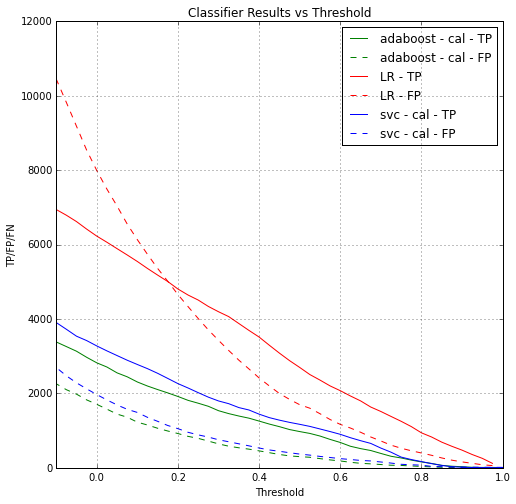

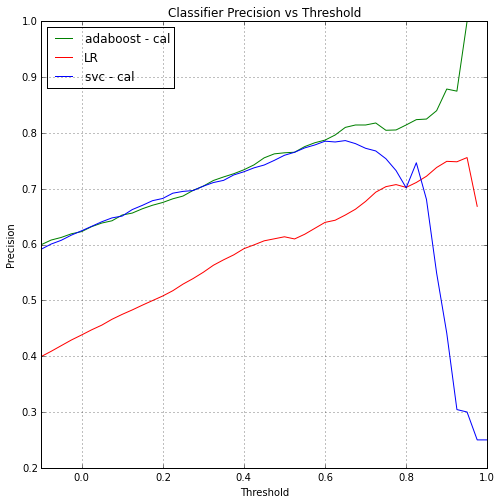

In [21]:
plotCombinedResults(subset5)

In [22]:
Y_test = np.concatenate([r['Y_test'] for r in all_results['LR']])

In [23]:
y_prob_net_avg = np.mean(
                     np.vstack([np.concatenate([r['y_prob_net']
                                                for r in all_results[k]])
                                for k in ['adaboost - cal',
                                          'LR',
                                          'svc - cal']]),
                               axis=0)
print y_prob_net_avg.shape
dummy_result = [{'Y_test': Y_test, 'y_prob_net': y_prob_net_avg}]

(50000,)


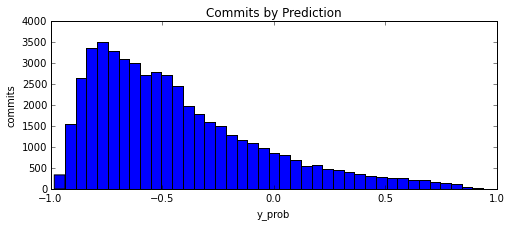

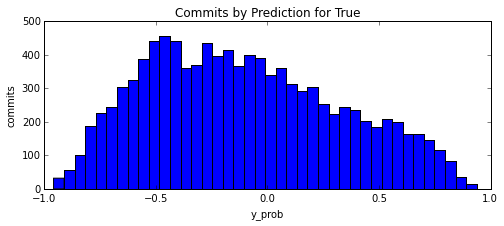

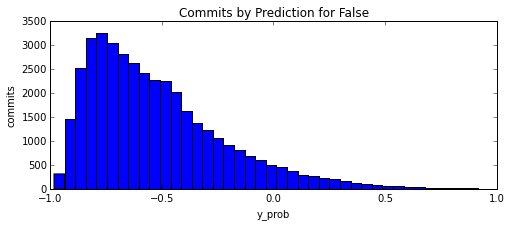

In [24]:
plotThresholdDistribuition(dummy_result)

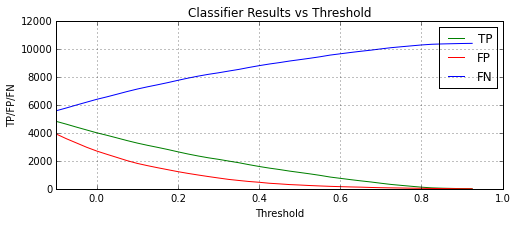

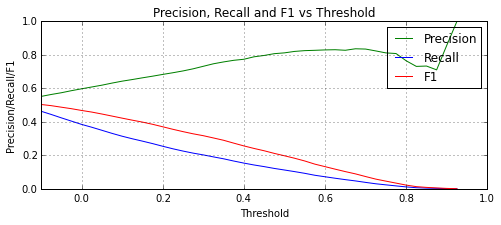

In [25]:
plotPredictionStats(dummy_result)

##Combine LR and LR-none

In [26]:
thresh_offset = -0.2
y_prob_net_avg = np.mean(
                     np.vstack([np.concatenate([r['y_prob_net']
                                                for r in all_results[k]])
                                for k in ['LR-none',
                                          'LR']]),
                               axis=0)
print y_prob_net_avg.shape
dummy_result = [{'Y_test': Y_test,
                 'y_prob_net': y_prob_net_avg + thresh_offset}]

(50000,)


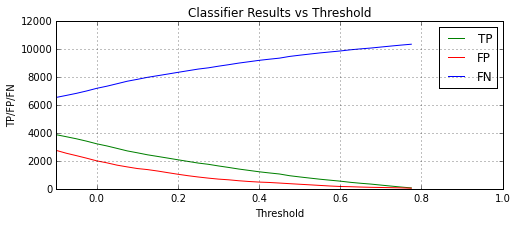

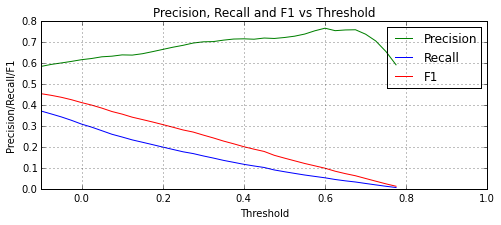

In [27]:
plotPredictionStats(dummy_result)

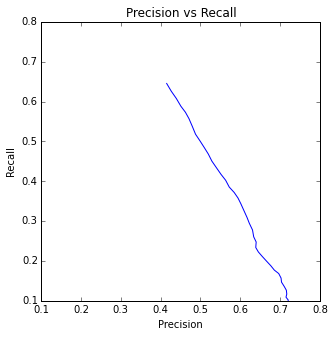

In [28]:
plotPrecisionRecall(dummy_result)